In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
import pandas as pd

In [8]:
#Time that will be used to interpolate. One of the datasets () is begins 100kyr, so interpolation begins here.
times = np.arange(101, 800, .1)

def normalize_01(vector):
    peak = np.max(vector - np.average(vector))
    return (vector - np.average(vector)) / peak

In [9]:
#Data 1: Lisiecki and Raymos
#Delta18-O going back 800kyr
with open('delta18O.txt', 'r') as file:
    lr_text = file.read().splitlines()
lr_text = [item.split("\t") for item in lr_text]
lr_time = [float(item[0]) for item in lr_text]
lr_delta18 = [float(item[1]) for item in lr_text]
lr_delta18_func = interp1d(lr_time, lr_delta18)
lr_delta18 = [lr_delta18_func(item) for item in times]
lr_delta18 = normalize_01(lr_delta18)

# Data 2: Laskar Insolation
#Insolation going back 800kyr
with open('insol5000copy.txt', 'r') as file:
    text = file.read().splitlines()
text = [item.split("    ") for item in text]
laskar_times = [abs(float(item[1])) for item in text]
laskar_insol = [float(item[2]) for item in text]
laskar_times = laskar_times[::-1] #Flipping lists, abs, so they are they are in the same time when interpolating
laskar_insol = laskar_insol[::-1]
laskar_insol_func = interp1d(laskar_times, laskar_insol)
laskar_insol = [laskar_insol_func(item) for item in times]
laskar_insol = normalize_01(laskar_insol)

#Data Set 3: DomeC_d18O
#Delta18-O 100-800kyr
domec = pd.read_csv(r"DomeC_d18O.csv")
domec_kyr = [float(timeitem[1]) for timeitem in [item[0].split() for item in np.asarray(domec)]]
domec = [float(timeitem[2]) for timeitem in [item[0].split() for item in np.asarray(domec)]]
domec_func = interp1d(domec_kyr, domec)
domec_int = [domec_func(item) for item in times]
domec_int = normalize_01(domec_int)

In [10]:
def add_dimensions(vector, d, tau):
    #takes a time series (vector) and returns a matrix
    #d is the total number of dimensions you want
    N = len(vector)
    matrix = np.zeros((N, d))
    for i in range(0, d):
        matrix[0:(N - i*tau), i] = vector[i*tau:N]
        matrix[(N - i*tau):N, i] = vector[0:i*tau]
    return matrix

In [44]:
def compute_mle(vector, dimension=3, tau=2, k=25, move_perc=.2, start_perc=.25, plot=False):    
    #move_perc = percent of data you want to search across
    N = len(vector)
    start = int(N * start_perc)
    stop = int(N * move_perc)
    recon = add_dimensions(vector.flatten(), dimension, 2)
    tree = KDTree(recon) 
    dd, ii = tree.query(recon[start], k=k)
    ii = ii[1:]
    max_index_possible = N - stop
    ii = [ii[j] for j in range(0, len(ii)) if ii[j] < max_index_possible]
    kcut = len(ii)
    
    if plot: print("LEN: ", N, " START INDEX: ", start, " STOP INDEX: ", stop+start)
    
    taus = np.arange(0, stop, 1)
    overtaus = np.zeros((len(taus)))
    dists = np.zeros((kcut, stop))
    scdists = np.zeros((kcut, stop))
    ndists = np.zeros((kcut, stop))
    for tau in taus:
        for i in range(0, kcut):
            ndists[i, tau] = np.linalg.norm(recon[start+tau] - recon[ii[i]+tau])

    if plot:
        plt.plot(np.average(ndists, axis=0))
        plt.show()
        
    mle = np.average(np.log2(abs(np.average(ndists, axis=0))))
    return mle

def multi_mle(vector, numpts=15, dimension=3, tau=2, k=25, move_perc=.2, start_perc=.25):
    avgmle = 0
    eps = np.random.rand(numpts) / 20
    eps = [ep*-1 if np.random.rand(1) < .5 else ep for ep in eps ]
    print("EPSILONS: ", eps)
    for i in range(0, numpts):
        avgmle += compute_mle(vector, dimension=dimension, tau=tau, k=k, move_perc=move_perc, start_perc=start_perc+eps[i])
    return avgmle / numpts

LEN:  6990  START INDEX:  349  STOP INDEX:  390


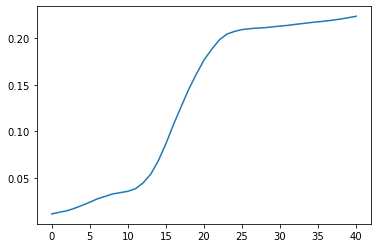

-3.4197770523850655

In [45]:
# mle1 = compute_mle(lr_delta18, dimension=3, move_perc=.012, start_perc=.05, plot=True)
# mle1 = compute_mle(laskar_insol, dimension=4, move_perc=.025, start_perc=.05, plot=True)
mle1 = compute_mle(domec_int, dimension=4, move_perc=.006, start_perc=.05, plot=True)
mle1

In [ ]:
#Insolation: -1.97
#LR:         -2.67
#Dome C:     -3.42